In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import shutil,time,os
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm
# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
# !pip install num2words
from num2words import num2words
# !pip install pyspellchecker
# from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
import gensim
from sklearn.decomposition import TruncatedSVD

# Load Data

In [71]:
input_data=pd.read_csv("./ecommerceDataset.csv",names=["Label","describtion"])
input_data.head(2)

,Label,describtion
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."


In [72]:
input_data.isna().sum()

Label          0
describtion    1
dtype: int64

In [73]:
input_data.shape

(50425, 2)

In [74]:
input_data.dropna(inplace=True)

In [75]:
input_data.isna().sum()

Label          0
describtion    0
dtype: int64

In [76]:
input_data.shape

(50424, 2)

# Remove Duplicate

In [77]:
input_data.drop_duplicates(subset="describtion",inplace=True)

In [78]:
input_data.shape

(27802, 2)

# Prepare Data For Word Embedding Model Training 

In [79]:
input_data.head(5)

,Label,describtion
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [80]:
input_data['Label'] = '__label__' + input_data['Label'].astype(str)
input_data.head(2)

,Label,describtion
0,__label__Household,Paper Plane Design Framed Wall Hanging Motivat...
1,__label__Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."


In [84]:
input_data["label_describtion"]=input_data['Label'] + ' ' + input_data['describtion']
input_data.head(2)

,Label,describtion,label_describtion
0,__label__Household,Paper Plane Design Framed Wall Hanging Motivat...,__label__Household Paper Plane Design Framed W...
1,__label__Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",__label__Household SAF 'Floral' Framed Paintin...


In [85]:
def pre_processing_fasttext(inp_text):
    inp_text = re.sub(r'[^\w\s\']',' ', inp_text)
    inp_text = re.sub(' +', ' ', inp_text)
    return inp_text.strip().lower() 

In [87]:
input_data["pre_processed_describtion"]=input_data["label_describtion"].apply(lambda x:pre_processing_fasttext(x))
input_data

,Label,describtion,label_describtion,pre_processed_describtion
0,__label__Household,Paper Plane Design Framed Wall Hanging Motivat...,__label__Household Paper Plane Design Framed W...,__label__household paper plane design framed w...
1,__label__Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",__label__Household SAF 'Floral' Framed Paintin...,__label__household saf 'floral' framed paintin...
2,__label__Household,SAF 'UV Textured Modern Art Print Framed' Pain...,__label__Household SAF 'UV Textured Modern Art...,__label__household saf 'uv textured modern art...
3,__label__Household,"SAF Flower Print Framed Painting (Synthetic, 1...",__label__Household SAF Flower Print Framed Pai...,__label__household saf flower print framed pai...
4,__label__Household,Incredible Gifts India Wooden Happy Birthday U...,__label__Household Incredible Gifts India Wood...,__label__household incredible gifts india wood...
...,...,...,...,...
50402,__label__Electronics,Micromax Bharat 5 Plus Zero impact on visual d...,__label__Electronics Micromax Bharat 5 Plus Ze...,__label__electronics micromax bharat 5 plus ze...
50403,__label__Electronics,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,__label__Electronics Microsoft Lumia 550 8GB 4...,__label__electronics microsoft lumia 550 8gb 4...
50407,__label__Electronics,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",__label__Electronics Microsoft Lumia 535 (Blac...,__label__electronics microsoft lumia 535 black...
50408,__label__Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,__label__Electronics Karbonn Titanium Wind W4 ...,__label__electronics karbonn titanium wind w4 ...


# Target Column Encoding 

In [59]:
from sklearn.preprocessing import LabelEncoder
label_encode=LabelEncoder()
input_data["Label"]=label_encode.fit_transform(input_data["Label"])

In [60]:
input_data["Label"].value_counts()

Label
3    10564
0     6256
1     5674
2     5308
Name: count, dtype: int64

In [88]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(input_data, test_size=0.2)

In [89]:
train.to_csv("ecommerce.train", columns=["pre_processed_describtion"], index=False, header=False)
test.to_csv("ecommerce.test", columns=["pre_processed_describtion"], index=False, header=False)

In [93]:
train.to_csv("ecommerce.train", columns=["pre_processed_describtion"], index=False, header=False)
test.to_csv("ecommerce.test", columns=["pre_processed_describtion"], index=False, header=False)

In [94]:
import fasttext

In [95]:
model = fasttext.train_supervised(input="ecommerce.train")
model.test("ecommerce.test")

Read 2M words
Number of words:  75723
Number of labels: 4
Progress: 100.0% words/sec/thread: 2375975 lr:  0.000000 avg.loss:  0.262323 ETA:   0h 0m 0s


(5561, 0.9485704010070132, 0.9485704010070132)

# Model Evaluation

In [114]:
final_prediction_on_test=[]
for s_row in test.iterrows():
    s_row_temp_data={}
    input_text_description=s_row[1][-1]
    input_text_description=" ".join(input_text_description.split(" ")[1:])
    s_row_temp_data["prediction"]=model.predict(input_text_description)[0][0].split("_")[-1]
    s_row_temp_data["curation"]=s_row[1][-1].split(" ")[0].split("_")[-1]
    final_prediction_on_test.append(s_row_temp_data)

In [115]:
Final_Prediction_dataframe=pd.DataFrame(final_prediction_on_test)
Final_Prediction_dataframe.head(2)

,prediction,curation
0,household,household
1,household,electronics


              precision    recall  f1-score   support

       books       0.95      0.93      0.94      1303
    clothing       0.98      0.98      0.98      1056
 electronics       0.93      0.92      0.93      1070
   household       0.94      0.96      0.95      2132

    accuracy                           0.95      5561
   macro avg       0.95      0.95      0.95      5561
weighted avg       0.95      0.95      0.95      5561



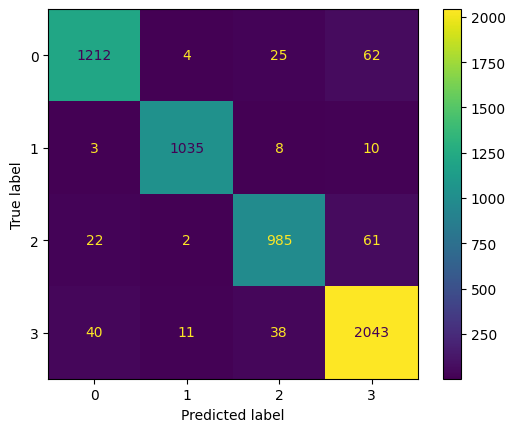

In [116]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
print(classification_report(Final_Prediction_dataframe.curation,Final_Prediction_dataframe.prediction))
cm=confusion_matrix(Final_Prediction_dataframe.curation,Final_Prediction_dataframe.prediction)
disp=ConfusionMatrixDisplay(cm)
disp.plot()